<a href="https://colab.research.google.com/github/masher5764/Final_yr_project_Cluster_GCN/blob/main/final_yr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Train Loss: 0.5613, Val Loss: 0.1960
Epoch 2, Train Loss: 0.5348, Val Loss: 0.2287
Epoch 3, Train Loss: 0.5293, Val Loss: 0.2146
Epoch 4, Train Loss: 0.5258, Val Loss: 0.2243
Epoch 5, Train Loss: 0.5215, Val Loss: 0.2574
Epoch 6, Train Loss: 0.5172, Val Loss: 0.2740
Epoch 7, Train Loss: 0.5137, Val Loss: 0.2423
Epoch 8, Train Loss: 0.5089, Val Loss: 0.2330
Epoch 9, Train Loss: 0.5062, Val Loss: 0.2452
Epoch 10, Train Loss: 0.5047, Val Loss: 0.2481
Epoch 11, Train Loss: 0.5028, Val Loss: 0.2630
Epoch 12, Train Loss: 0.5025, Val Loss: 0.2442
Early stopping
Silhouette Score: 0.4904
Davies-Bouldin Score: 0.7472
Calinski-Harabasz Score: 2953.9084


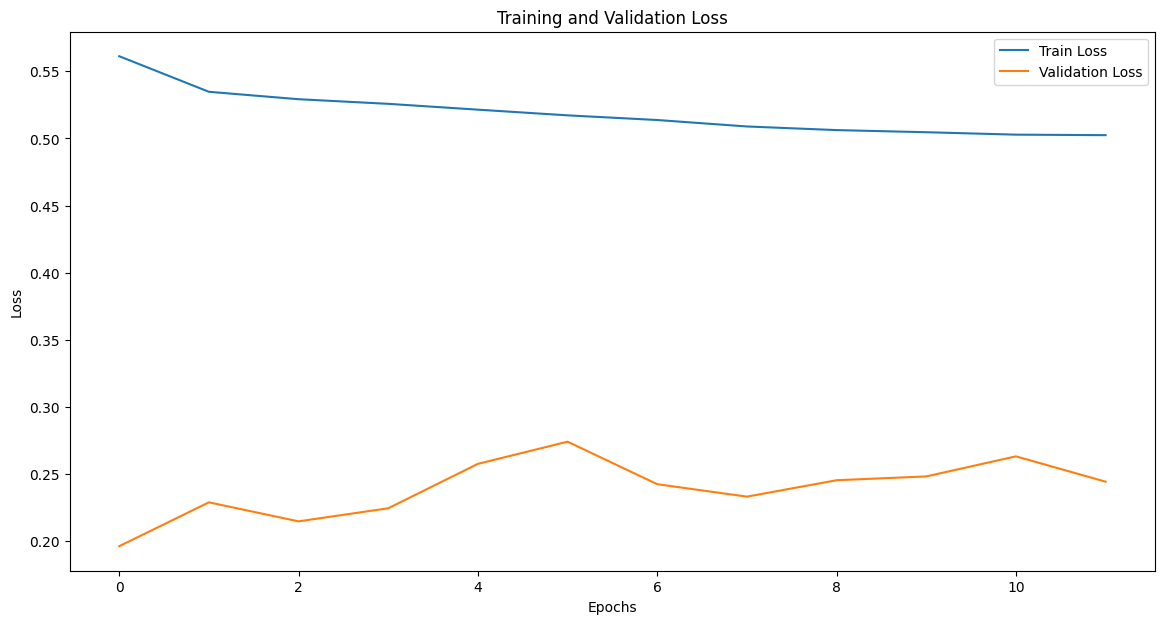

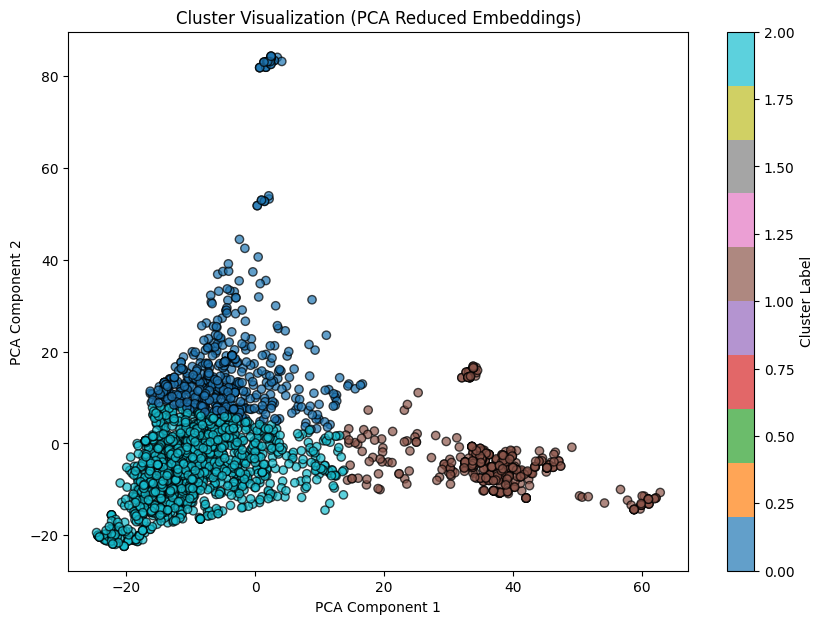

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import ast

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encode RNA sequences and structures
def encode_sequence(sequence):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
    return np.array([mapping[char] for char in sequence], dtype=np.int64)

def encode_structure(structure):  #  . for unpaired bases, ( for opening base-pairs, ) for closing base-pairs.
    mapping = {'.': 0, '(': 1, ')': 2}
    return np.array([mapping[char] for char in structure], dtype=np.int64)

def encode_loop_type(loop_type):
    mapping = {'S': 0, 'M': 1, 'I': 2, 'B': 3, 'H': 4, 'E': 5, 'X': 6}
    return np.array([mapping[char] for char in loop_type], dtype=np.int64)

# Create adjacency matrix for RNA graph
def convert_to_adj(structure):
    n = len(structure)
    adj = np.eye(n, dtype=np.float32)
    stack = []
    for i, char in enumerate(structure):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            adj[i, j] = 1
            adj[j, i] = 1
    return adj

class RNADataset(Dataset):
    def __init__(self, data, max_len=None):
        self.data = data # sequence, structure, predicted_loop_type, and targets.
        self.max_len = max_len if max_len else self.find_max_len() #  longest RNA sequence

    def find_max_len(self):
        return max(len(seq) for seq in self.data['sequence'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        sequence = encode_sequence(item['sequence'])
        structure = encode_structure(item['structure'])
        loop_type = encode_loop_type(item['predicted_loop_type'])

        # Pads each encoded array with zeros to ensure they all have the same length to self.max_len
        sequence = np.pad(sequence, (0, self.max_len - len(sequence)), 'constant')
        structure = np.pad(structure, (0, self.max_len - len(structure)), 'constant')
        loop_type = np.pad(loop_type, (0, self.max_len - len(loop_type)), 'constant')

        adj = convert_to_adj(item['structure']) # Generate adjacency matrix

        # Pad adjacency matrix to max_len x max_len
        adj_padded = np.zeros((self.max_len, self.max_len), dtype=np.float32)
        adj_padded[:adj.shape[0], :adj.shape[1]] = adj

        features = np.stack([sequence, structure, loop_type], axis=1) # single feature tensor of shape (max_len, 3) -> (sequence, structure, and loop_type)

        # Extract target columns
        targets = []
        for target_col in ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']:
            try:
                targets.append(ast.literal_eval(item[target_col])) # parse the string
            except KeyError:
                targets.append([0.0] * 68) # default

        targets = np.array(targets, dtype=np.float32)

        return (
            torch.tensor(features, dtype=torch.float32),
            torch.tensor(adj_padded, dtype=torch.float32),
            torch.tensor(targets, dtype=torch.float32),
        )

# GCN Layer
class GCN(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCN, self).__init__()
        self.fc = nn.Linear(in_features, out_features)  # transform node features from in_features to out_features
        self.relu = nn.ReLU()  # non-linearity
        self.batch_norm = nn.BatchNorm1d(out_features)

    def forward(self, x, adj):             # x: (batch_size, num_nodes, in_features),  adj: (batch_size, num_nodes, num_nodes)
        out = torch.matmul(adj, x)  # Node Feature Aggregation
        out = self.fc(out)  # transform them into the desired output dimension (out_features)
        out = self.batch_norm(out.permute(0, 2, 1)).permute(0, 2, 1)
        return self.relu(out)

# GCN-based Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(3, 64)  # (sequence, structure, loop_type)
        self.gcn2 = GCN(64, 128)
        self.gru = nn.GRU(128, 256, batch_first=True, bidirectional=True) # Input:128, Hidden Size: 256, forward and backward GRU passes, producing output with twice the hidden size (512)
        self.fc1 = nn.Linear(256 * 2, 128)  # Input: 512 features (Bidirectional GRU output), Output: Reduces dimensionality to 128.
        self.fc2 = nn.Linear(128, 68 * 3)   # Input: 128 features, Output: Produces predictions for 68 positions and 3 target values (reactivity, deg_Mg_pH10, deg_Mg_50C).

    def forward(self, features, adj):
        x = self.gcn1(features, adj)  # 64 dimensions.
        x = self.gcn2(x, adj)  # 128 dimensions.
        x, _ = self.gru(x)  # (128 → 256 × 2 for bidirectional GRU).
        x = torch.mean(x, dim=1)  # Global pooling : this reduces all the node features into a single global representation by averaging.
        x = self.fc1(x) # fc1: Reduces dimensionality from 512 to 128
        x = self.fc2(x) # fc2: Produces final predictions of shape (batch_size, 68 × 3).
        return x.view(x.size(0), 3, 68) # 3: Target values (reactivity, deg_Mg_pH10, deg_Mg_50C), 68: Number of positions in the sequence.

# Training and Validation
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs):
    best_val_loss = float('inf')
    patience_counter = 0
    patience_limit = 10

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()  # Sets the model to training mode.
        train_loss = 0.0
        for features, adj, targets in train_loader: # train_loader: (features, adj, targets)
            features, adj, targets = features.to(device), adj.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features, adj)  # Forward Pass
            loss = criterion(outputs, targets) # Compute Loss
            loss.backward() # Backward Pass
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping: If a gradient's norm exceeds 1.0, it is scaled down to meet the limit, ensuring training stability
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, adj, targets in val_loader:
                features, adj, targets = features.to(device), adj.to(device), targets.to(device)
                outputs = model(features, adj)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)  # The learning rate scheduler adjusts the learning rate based on the validation loss.

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter > patience_limit:
                print("Early stopping")
                break

    return train_losses, val_losses

# Clustering Evaluation
# Perform clustering with fixed number of clusters
def perform_clustering(model, data_loader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for features, adj, _ in data_loader:
            features, adj = features.to(device), adj.to(device)
            outputs = model.gcn2(model.gcn1(features, adj), adj)
            embeddings.append(outputs.cpu().numpy()) # Use gcn1(processed feature data) -> gcn2 -> embeddings(numpy array)
    embeddings = np.concatenate(embeddings, axis=0)  # This combines all the embeddings obtained from different batches in the data loader into a single numpy array.
    embeddings = embeddings.reshape(embeddings.shape[0], -1) # Reshapes the embeddings to have one row per sample, where the number of columns corresponds to the feature vector dimension of each sample.

    pca = PCA(n_components=2) # 2D space for easy visualization
    reduced_embeddings = pca.fit_transform(embeddings) # The transformed embeddings (reduced_embeddings) are then ready for clustering.

    kmeans = KMeans(n_clusters=3, random_state=0)  # Fixed number of clusters
    cluster_labels = kmeans.fit_predict(reduced_embeddings)

    return reduced_embeddings, cluster_labels

# Main function
if __name__ == "__main__":
    train_data = pd.read_csv('train.csv')
    val_data = pd.read_csv('test.csv')

    train_dataset = RNADataset(train_data)
    val_dataset = RNADataset(val_data)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = Net().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Changed to AdamW for better weight regularization
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    train_losses, val_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=200)

    embeddings, cluster_labels = perform_clustering(model, train_loader)

    # Silhouette, Davies-Bouldin, and Calinski-Harabasz metrics
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    db_score = davies_bouldin_score(embeddings, cluster_labels)
    ch_score = calinski_harabasz_score(embeddings, cluster_labels)

    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")

    # Visualize the results
    plt.figure(figsize=(14, 7))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    # Visualize the embeddings with clusters
    plt.figure(figsize=(10, 7))
    plt.scatter(
        embeddings[:, 0], embeddings[:, 1],
        c=cluster_labels, cmap='tab10', alpha=0.7, edgecolors='k'
    )
    plt.title("Cluster Visualization (PCA Reduced Embeddings)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster Label")
    plt.show()


In [ ]:
def elbow_method(embeddings, max_clusters=10):
    wcss = []
    cluster_range = range(1, max_clusters + 1)

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, wcss, marker='o', linestyle='--')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.title("Elbow Method for Optimal Clusters")
    plt.grid()
    plt.show()

    return wcss


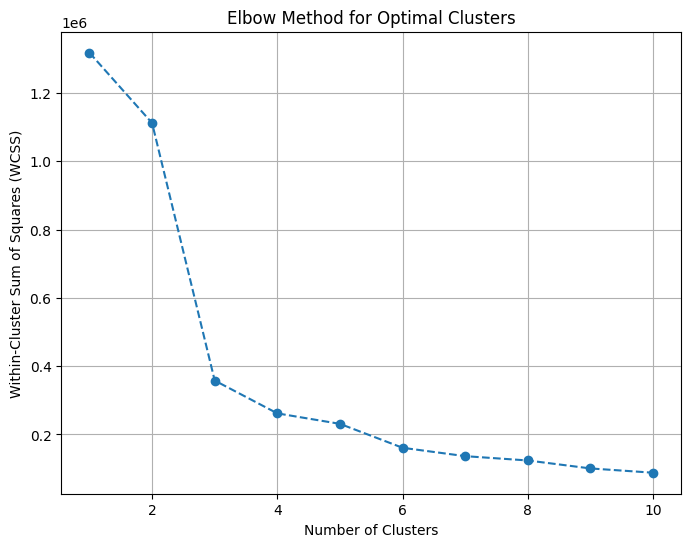

In [ ]:
# Perform clustering and extract embeddings
embeddings, _ = perform_clustering(model, train_loader, num_clusters=5)  # Use a default number of clusters for initial embeddings

# Determine the optimal number of clusters using the Elbow Method
wcss = elbow_method(embeddings, max_clusters=10)
